
# Zillow Prize:  Zillow’s Home Value Prediction (Zestimate)

# Can Xu  ,cx461@nyu.edu


https://www.kaggle.com/c/zillow-prize-1#evaluation

Kaggle Zillow Competetion

<img src="https://www.kaggle.com/static/images/site-logo.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gc
import pandas as pd
import xgboost as xgb

%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the data.  Use the `index_col` option to specify that column 0 (the one with time) is the *index* column.  You can review [simple linear regression demo](../simp_lin_reg/auto_mpg.ipynb) for examples of using the `pd.read_csv` command.

In [5]:
print('Loading data ...')

train = pd.read_csv('./data/train_2016_v2.csv')
prop = pd.read_csv('./data/properties_2016.csv')
sample = pd.read_csv('./data/sample_submission.csv')

Loading data ...


g:\code\python\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [6]:



print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)
        
train.head(6)

Binding to float32


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
5,11509835,-0.2705,2016-01-02


In [7]:
prop.head(6)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.280029,NaN,NaN,NaN


In [8]:
sample.head(6)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0
5,10898347,0,0,0,0,0,0


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.  

In [9]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values

Creating training set ...


In [10]:
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

(90275, 55) (90275,)


In [11]:
print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect()

Building DMatrix...


0

In [12]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

del d_train, d_valid

Training ...
[0]	train-mae:0.488065	valid-mae:0.48112
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402221	valid-mae:0.395444
[20]	train-mae:0.33268	valid-mae:0.326098
[30]	train-mae:0.276518	valid-mae:0.270132
[40]	train-mae:0.231316	valid-mae:0.225213
[50]	train-mae:0.195059	valid-mae:0.189317
[60]	train-mae:0.166121	valid-mae:0.16072
[70]	train-mae:0.143115	valid-mae:0.138042
[80]	train-mae:0.124973	valid-mae:0.120213
[90]	train-mae:0.11079	valid-mae:0.106351
[100]	train-mae:0.099822	valid-mae:0.095702
[110]	train-mae:0.091454	valid-mae:0.087592
[120]	train-mae:0.085149	valid-mae:0.08158
[130]	train-mae:0.080456	valid-mae:0.077192
[140]	train-mae:0.077015	valid-mae:0.074063
[150]	train-mae:0.07451	valid-mae:0.071827
[160]	train-mae:0.072688	valid-mae:0.070245
[170]	train-mae:0.071374	valid-mae:0.069129
[180]	train-mae:0.070415	valid-mae:0.068366
[190]	train-mae:0.069715

In [13]:
print('Building test set ...')

sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

del prop; gc.collect()

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

del df_test, sample; gc.collect()

d_test = xgb.DMatrix(x_test)

del x_test; gc.collect()


Building test set ...


g:\code\python\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


7

In [14]:
print('Predicting on test ...')

p_test = clf.predict(d_test)

del d_test; gc.collect()



Predicting on test ...


0

In [16]:
sub = pd.read_csv('./data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('xgb_starter.csv', index=False, float_format='%.4f') # Thanks to @inversion

Writing csv ...


## Measure the Fit on an Indepdent Dataset

Load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

Measure the normalized RSS on the test data.  Is it substantially higher than the training data?

In [12]:
print(regr.coef_);



[ 0.06255018  0.20584896  0.00118784  0.00044457 -0.0031362   0.00603298
  0.05487097]


In [13]:
y_tr_pred = regr.predict(Xtrain)
RSS_tr = np.mean((y_tr_pred-ytrain)**2)/(np.std(ytrain)**2)
Rsq_tr = 1-RSS_tr
print("RSS per sample = {0:f}".format(RSS_tr))
print("R^2 =            {0:f}".format(Rsq_tr))

RSS per sample = 0.126780
R^2 =            0.873220


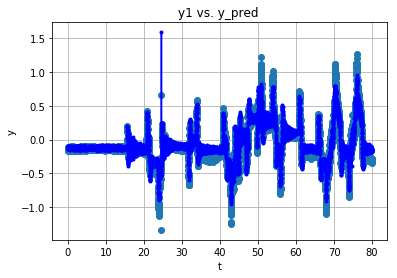

In [14]:
plt.figure(2)

plt.plot(t,y1,'o',t,y_tr_pred,'b.-')
plt.title('y1 vs. y_pred ')
plt.xlabel('t')
plt.ylabel('y')
plt.grid(True)